# Industry is the objective of the project

In order to optimize production costs, the metallurgical plant Tak Temper Steel LLC decided to reduce electricity consumption at the stage of steel processing. You have to build a model that predicts the temperature of the steel.

### Description of the processing step

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus (English tribe, "mass").

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks (English *slab*, “slab”).

### Description of data

The data consists of files obtained from different sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` *—* data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. There can be several lines in files with the same `key` value: they correspond to different processing iterations.

### Loop description

1. Steel is poured into a ladle and heated
2. Desulfurization

Cycle start:

3. Temperature measurement
4. Heating
5. Adding impurities and sampling
6. Steel is alloyed with loose and wire
7. Blowing with gas

End of cycle (n - repetitions)

7. Spill

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import catboost as cb
from catboost import CatBoostRegressor

import statsmodels.api as sm
from scipy.stats import kstest
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 281022
TEST_SPLIT = 0.25

### Initial data analysis

In [4]:
try:
    data_arc = pd.read_csv('~/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('~/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('~/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('~/final_steel/data_gas.csv')
    data_temp = pd.read_csv('~/final_steel/data_temp.csv')
    data_wire = pd.read_csv('~/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('~/final_steel/data_wire_time.csv')
except:
    print('Can not load')

Can not load


For a more convenient understanding of the data in the tables, we will consider them in turn each.

In [5]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    print('Can not load')

#### data_arc

In [6]:
display(data_arc.info())
display(data_arc.head(6))
display(data_arc.describe())
display(data_arc.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   
5    2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.438063   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397  
5             0.283043

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

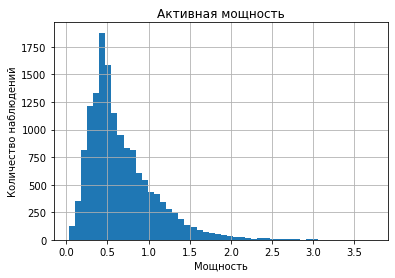

In [7]:
ax = data_arc['Активная мощность'].hist(bins=50)
ax.set_title('Активная мощность')
ax.set_xlabel('Мощность')
ax.set_ylabel('Количество наблюдений')
ax.plot();

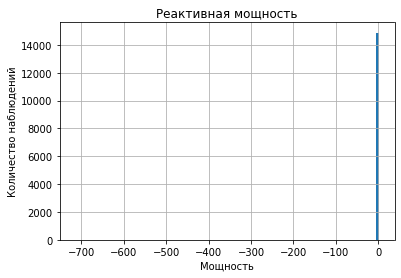

In [8]:
ax = data_arc['Реактивная мощность'].hist(bins=100)
ax.set_title('Реактивная мощность')
ax.set_xlabel('Мощность')
ax.set_ylabel('Количество наблюдений')
ax.plot();

We see that we have an outlier, let's try to understand how many of them.

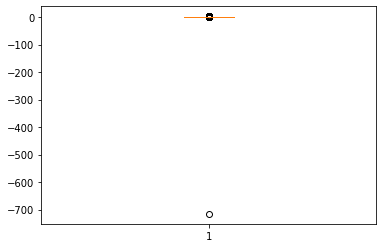

In [9]:
plt.boxplot(data_arc['Реактивная мощность']);

Only one, let's remove it.

In [10]:
data_arc[data_arc['Реактивная мощность']<-715]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37           0.495782   

      Реактивная мощность  
9780          -715.504924

In [11]:
data_arc = data_arc.drop(data_arc[data_arc['key'] == 2116].index)
data_arc.reset_index(drop=True, inplace=True)

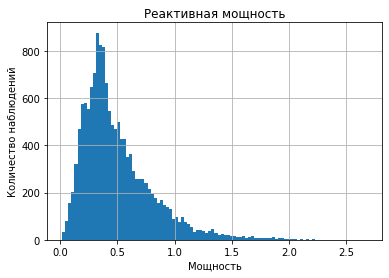

In [12]:
ax = data_arc['Реактивная мощность'].hist(bins=100)
ax.set_title('Реактивная мощность')
ax.set_xlabel('Мощность')
ax.set_ylabel('Количество наблюдений')
ax.plot();

In [13]:
print('Уникальных key в таблице:', len(data_arc['key'].unique()))

Уникальных key в таблице: 3213


Found outlier and removed it.

What do you understand from the data:
the start time and end time of heating can be converted into heating duration.\
active and reactive power - in full according to the formula:
$$ S = \sqrt[]{ P^2 + Q^2 } $$
Where:\
P - Active power\
Q - Reactive power
You can represent the heating time and the total power as work:
$$ A = S \cdot t $$
Where:\
S - full power
t is the heating time.

In [14]:
data_arc[data_arc['Реактивная мощность'] > 0.1]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0         1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1         1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2         1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3         1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4         1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   
...     ...                  ...                  ...                ...   
14867  3241  2019-09-01 03:58:58  2019-09-01 04:01:35           0.533670   
14868  3241  2019-09-01 04:05:04  2019-09-01 04:08:04           0.676604   
14869  3241  2019-09-01 04:16:41  2019-09-01 04:19:45           0.733899   
14870  3241  2019-09-01 04:31:51  2019-09-01 04:32:48           0.220694   
14871  3241  2019-09-01 04:34:47  2019-09-01 04:36:08           0.306580   

       Реактивная мощность  
0                 0.687084  
1                 0.520285  
2                 0.498805  
3                 1.062669  
4                 0.414397  
...                    ...  
14867             0.354439  
14868             0.523631  
14869             0.475654  
14870             0.145768  
14871             0.196708  

[14610 rows x 5 columns]

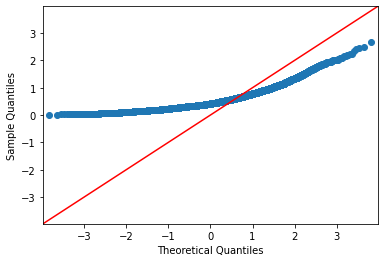

In [15]:
fig = sm.qqplot(data_arc['Реактивная мощность'], line='45')
plt.show()

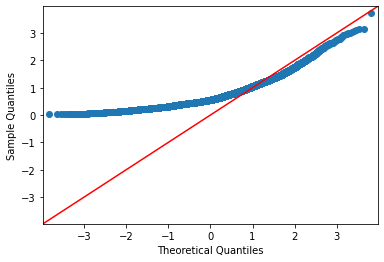

In [16]:
fig = sm.qqplot(data_arc['Активная мощность'], line='45')
plt.show()

In [17]:
print('Реактивная мощность',kstest(data_arc['Активная мощность'], 'norm'))
print('Активная мощность',kstest(data_arc['Реактивная мощность'], 'norm'))

Реактивная мощность KstestResult(statistic=0.5391259608662873, pvalue=0.0)
Активная мощность KstestResult(statistic=0.522580923848383, pvalue=0.0)


From tests for normality, it follows that we have a non-normal distribution.

#### data_bulk

In [18]:
display(data_bulk.info())
display(data_bulk.head())
display(data_bulk.describe())
display(data_bulk.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

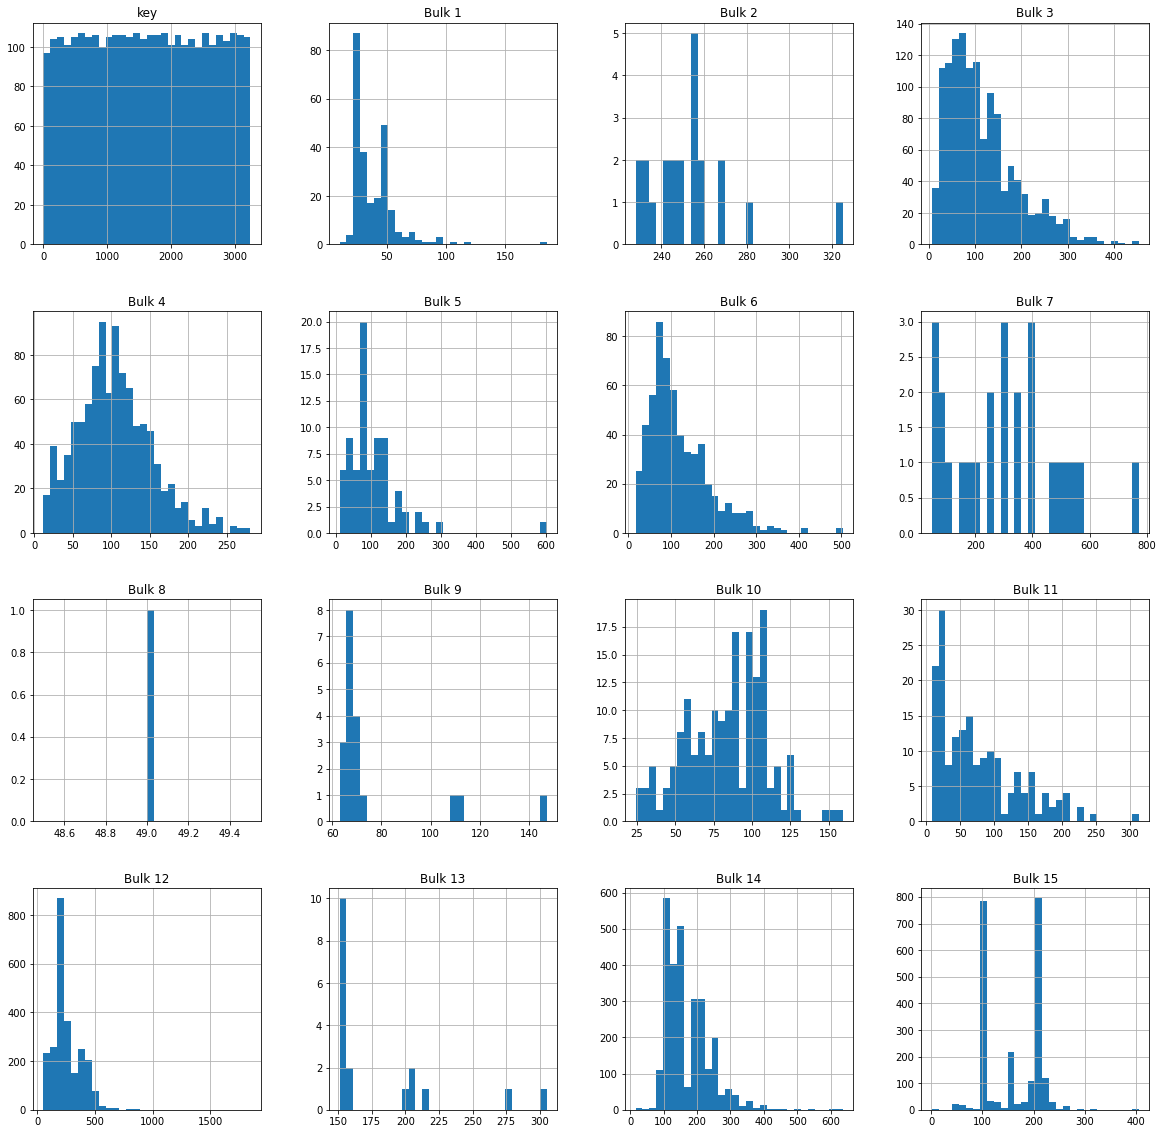

In [19]:
data_bulk.hist(bins=30, figsize=(20,20));

In [20]:
print('Уникальных key в таблице:', len(data_bulk['key'].unique()))

Уникальных key в таблице: 3129


Data on loading bulk alloying elements.\
There are a lot of NaNs, but there are no null values, so let's fill all NaNs with zeros.\
The number of unique `key` matches the number of lines - no gaps.\
Some signs are too few, for example `Bulk 8` occurs only 1 time.

Already by the histograms, we can say that this is not a normal distribution, but rather a Poisson one.

In [21]:
print('Bulk 1',kstest(data_bulk['Bulk 4'], 'norm'))

Bulk 1 KstestResult(statistic=nan, pvalue=nan)


#### data_bulk_time

In [22]:
display(data_bulk_time.info())
display(data_bulk_time.head())
display(data_bulk_time.describe())
display(data_bulk_time.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [23]:
print('Уникальных key в таблице:', len(data_bulk_time['key'].unique()))

Уникальных key в таблице: 3129


Data on the loading time of bulk alloying elements.\
A lot of NaN, we have to decide - how significant is the start time of loading the alloying element?
Should the loading time of the alloying element be correlated:
- and the size of the download or not (data_bulk)?
- and heating time (data_arc)?

The number of unique `key`s matches the number of lines - there are no gaps.

#### data_gas

In [24]:
display(data_gas.info())
display(data_gas.head())
display(data_gas.describe())
display(data_bulk_time.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [25]:
print('Уникальных key в таблице:', len(data_gas['key'].unique()))

Уникальных key в таблице: 3239


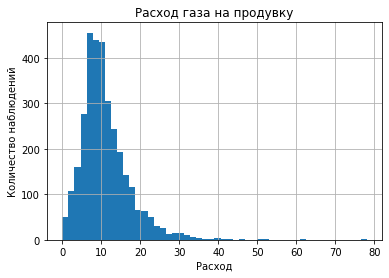

In [26]:
ax = data_gas['Газ 1'].hist(bins=50)
ax.set_title('Расход газа на продувку')
ax.set_xlabel('Расход')
ax.set_ylabel('Количество наблюдений')
ax.plot();

The number of unique `key`s matches the number of lines - there are no gaps.

#### data_temp

In [27]:
display(data_temp.info())
display(data_temp.head(6))
display(data_temp.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0
5    2  2019-05-03 11:37:27       1581.0

key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

In [28]:
print('Уникальных key в таблице:', len(data_temp['key'].unique()))

Уникальных key в таблице: 3216


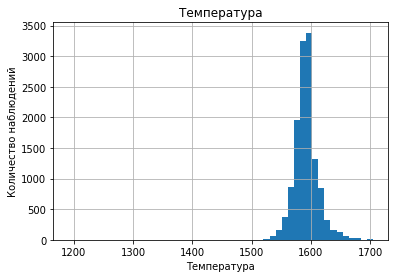

In [29]:
ax = data_temp['Температура'].hist(bins=50)
ax.set_title('Температура')
ax.set_xlabel('Температура')
ax.set_ylabel('Количество наблюдений')
ax.plot();

The number of unique `key`s is less than in the tables above.

This table contains the target feature, from which we begin to "collect" the complete table with features.

There are NaN in the `Temperature` column, we delete them. Batches without temperatures are not taken into account.


#### data_wire

In [30]:
display(data_wire.info())
display(data_wire.head())
display(data_wire.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

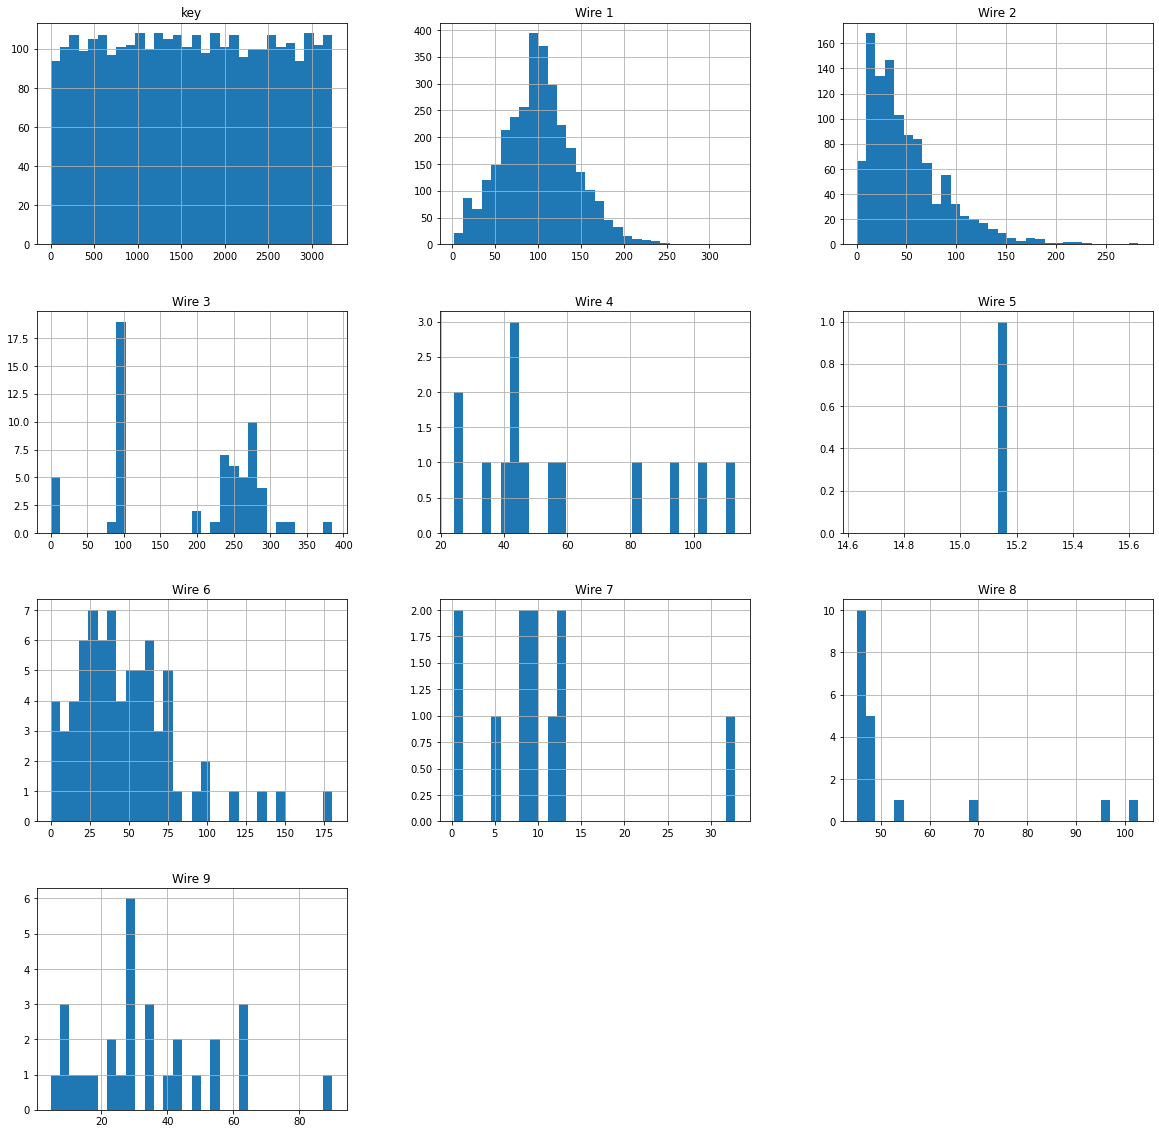

In [31]:
data_wire.hist(bins=30, figsize=(20,20));

In [32]:
print('Уникальных key в таблице:', len(data_wire['key'].unique()))

Уникальных key в таблице: 3081


The number of unique `key`s is less than in the tables above.

NaN is filled with zeros.

Some signs are too few, for example `Wire 5` occurs only 1 time.

#### data_wire_time

In [33]:
display(data_wire_time.info())
display(data_wire_time.head())
display(data_wire_time.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

The same as with the `data_bulk_time` table - it is not clear why we need the wire load time.

### List of planned works (upper level)

#### Table preprocessing before merging

**data_arc**\
Create a new column in which to calculate the total work and its amount for each batch of `key`

**data_bulk**\
Pad with NaNs
Additionally - make a pivot table with the number of non-zero fillings of each component and sort. The goal is to see the most commonly added alloying elements to the melt.

**data_bulk_time**\
Map to Data bulk table or don't use.
Or check the date of the posting, if it falls within the time interval for `key` in the table `data_arc`

**data_gas**\
We use it in the project as it is.

**data_temp**\
Extracting the initial temperature of each `key` is a feature.
And the final temperature, which is the target feature.

**data_wire**\
Pad with NaNs.
Additionally - make a pivot table with the number of non-zero fillings of each component and sort. The goal is to see the most commonly added alloying elements to the melt.

#### Join tables
We join tables by the `key` field using join.
As a result, we get a dataset with features and a target feature.
We check the shape of the distribution of the target feature, build a histogram.

#### Preparing data for research
**For linear regression**\
We create training and test sets with scaled features.

**For other models**\
Split into training and test sets

#### Research models and metrics

- Linear regression
- Random forest
- CatBoost

Metric: `MAE`

#### Choosing the best model and testing on a test set.
We test the best model and come to the conclusion whether it was possible to achieve the target metric.

### Data preprocessing
#### data_arc

Converting time from string type to datetime.

In [34]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(
    data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S'
)

data_arc['Конец нагрева дугой'] = pd.to_datetime(
    data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S'
)

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.1 KB


Calculation of heating time in sec `time_delta` , total power `S` and operation `A`

In [35]:
data_arc['time_delta'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['time_delta'] = data_arc['time_delta'].astype(int) / 10**9
data_arc['time_delta'] = data_arc['time_delta'].astype(int)

data_arc.head()

data_arc['S'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2) ** 0.5

data_arc['A'] = data_arc['time_delta'] * data_arc['S']

data_arc.head()

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.692755   

   Реактивная мощность  time_delta         S           A  
0             0.687084         228  1.193639  272.149755  
1             0.520285         185  0.959010  177.416785  
2             0.498805         172  0.896038  154.118502  
3             1.062669         365  1.970470  719.221394  
4             0.414397         148  0.807239  119.471318

Grouping and summing the values ​​in the `data_arc` table by `key`.

In [36]:
data_arc = data_arc.groupby('key').sum()

In [37]:
data_arc.head()

Активная мощность  Реактивная мощность  time_delta         S            A
key                                                                           
1             4.878147             3.183241        1098  5.826395  1442.377754
2             3.052598             1.998112         811  3.649216   881.233565
3             2.525882             1.599076         655  2.989534   525.066777
4             3.209250             2.060298         741  3.814962   796.911309
5             3.347173             2.252643         869  4.035758  1199.137958

array([[<AxesSubplot:title={'center':'Активная мощность'}>,
        <AxesSubplot:title={'center':'Реактивная мощность'}>],
       [<AxesSubplot:title={'center':'time_delta'}>,
        <AxesSubplot:title={'center':'S'}>],
       [<AxesSubplot:title={'center':'A'}>, <AxesSubplot:>]], dtype=object)

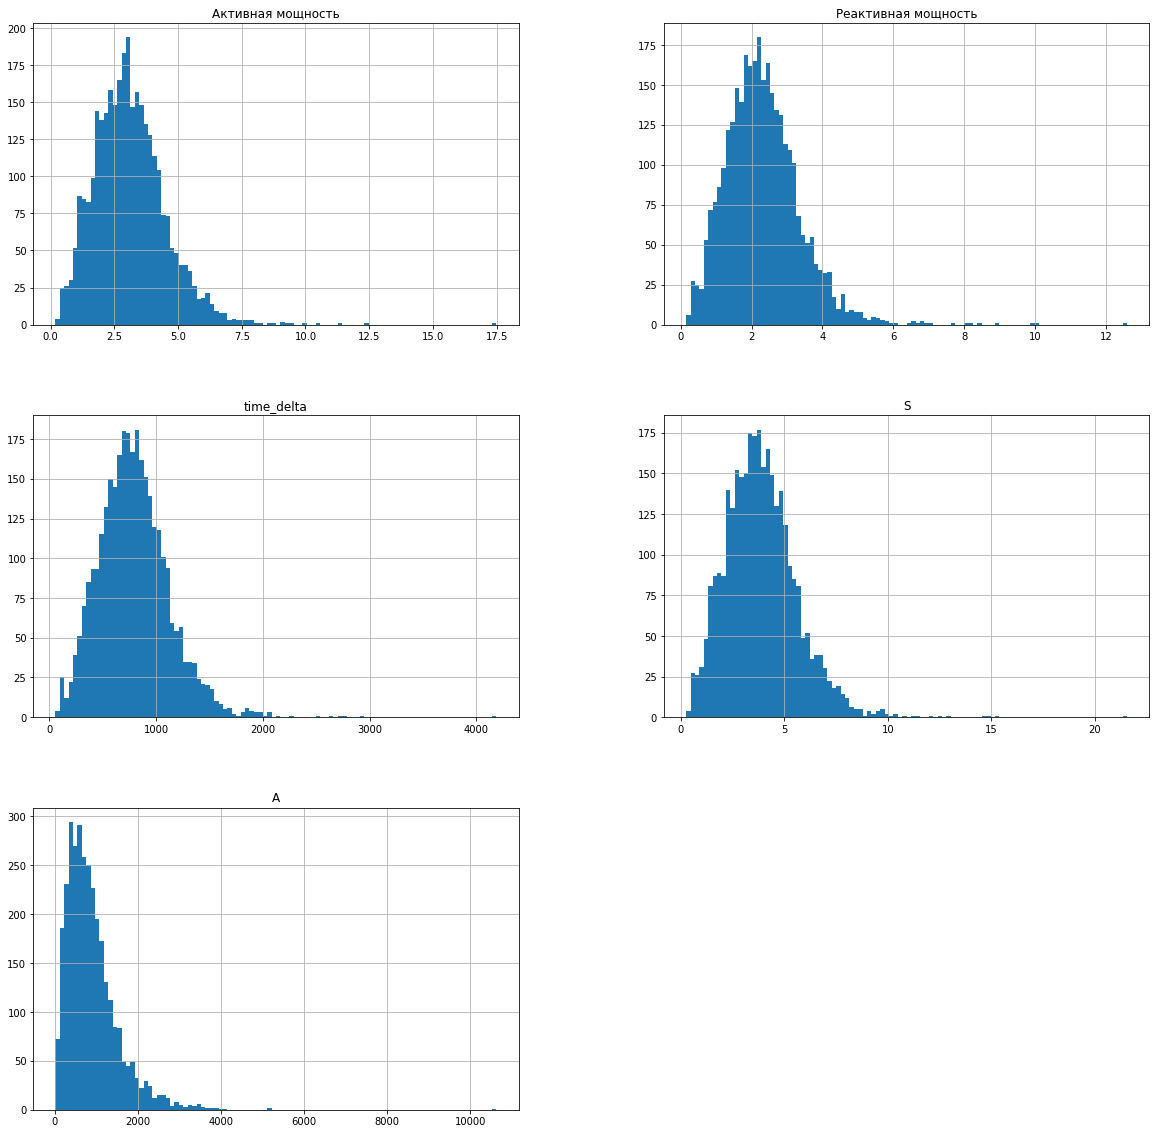

In [38]:
data_arc.hist(bins=100, figsize=(20,20))

#### data_bulk & data_wire

In [39]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)
display(data_bulk.head())
display(data_wire.head())

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

#### data_temp

Removing NaNs

In [40]:
data_temp = data_temp.dropna()

In [41]:
data_temp

key         Время замера  Температура
0         1  2019-05-03 11:16:18       1571.0
1         1  2019-05-03 11:25:53       1604.0
2         1  2019-05-03 11:29:11       1618.0
3         1  2019-05-03 11:30:01       1601.0
4         1  2019-05-03 11:30:39       1613.0
...     ...                  ...          ...
15878  3237  2019-08-31 22:44:04       1569.0
15883  3238  2019-08-31 23:30:31       1584.0
15886  3239  2019-09-01 01:31:47       1598.0
15894  3240  2019-09-01 02:39:01       1617.0
15902  3241  2019-09-01 04:03:30       1586.0

[13006 rows x 3 columns]

Removing single rows

In [42]:
num_of_keys = pd.DataFrame(data_temp.groupby('key')['key'].count())
indexes_to_delete = num_of_keys[num_of_keys['key'] == 1].index.tolist()
print('Indexes to delete count:', len(indexes_to_delete))
print('Indexes to delete [0] value:', indexes_to_delete[0])

Indexes to delete count: 741
Indexes to delete [0] value: 195


In [43]:
for i in indexes_to_delete:
    data_temp.drop(data_temp[data_temp['key'] == i].index, inplace=True)
data_temp.reset_index(drop=True, inplace=True)

In [44]:
data_temp[data_temp['key']==195]

Empty DataFrame
Columns: [key, Время замера, Температура]
Index: []

Cast

In [45]:
data_temp['Время замера'] = pd.to_datetime(
    data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S'
)

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12265 entries, 0 to 12264
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12265 non-null  int64         
 1   Время замера  12265 non-null  datetime64[ns]
 2   Температура   12265 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 287.6 KB


Start and end temperature.

In [46]:
max_data_temp = data_temp.groupby('key').agg('max')['Время замера'].reset_index()
max_data_temp = max_data_temp.merge(data_temp, on='Время замера', how='left', suffixes=('_tmp', ''))
max_data_temp = max_data_temp.drop(['key_tmp', 'Время замера'], axis=1)
max_data_temp = max_data_temp.dropna()

In [47]:
min_data_temp = data_temp.groupby('key').agg('min')['Время замера'].reset_index()
min_data_temp = min_data_temp.merge(data_temp, on='Время замера', how='left', suffixes=('_tmp', ''))
min_data_temp = min_data_temp.drop(['key_tmp', 'Время замера'], axis=1)
min_data_temp = min_data_temp.dropna()

In [48]:
max_data_temp = max_data_temp.rename(columns={"Температура": "target_temp"})
min_data_temp = min_data_temp.rename(columns={"Температура": "init_temp"})

In [49]:
display(max_data_temp)
display(min_data_temp)

key  target_temp
0        1       1613.0
1        2       1602.0
2        3       1599.0
3        4       1625.0
4        5       1602.0
...    ...          ...
2470  2495       1591.0
2471  2496       1591.0
2472  2497       1589.0
2473  2498       1594.0
2474  2499       1603.0

[2475 rows x 2 columns]

key  init_temp
0        1     1571.0
1        2     1581.0
2        3     1596.0
3        4     1601.0
4        5     1576.0
...    ...        ...
2470  2495     1570.0
2471  2496     1554.0
2472  2497     1571.0
2473  2498     1591.0
2474  2499     1569.0

[2475 rows x 2 columns]

#### Join tables

What signs are merjim?
- max_data_temp
- min_data_temp
- data_arc
- data_bulk
- data_wire
- data_gas

In [50]:
df = max_data_temp

In [51]:
df = df.merge(min_data_temp, on='key', how='left')
df = df.merge(data_arc, on='key', how='left')
df = df.merge(data_bulk, on='key', how='left')
df = df.merge(data_wire, on='key', how='left')
df = df.merge(data_gas, on='key', how='left')
df = df.drop(columns=['key', 'A', 'S'])

Removed `key`, `A` (work), `S` (full power) because in the process of doing work, the best metrics are obtained when the features are not combined into a complex entity, but are separated by physical meaning.

In [52]:
df.isna().sum()

target_temp              0
init_temp                0
Активная мощность        1
Реактивная мощность      1
time_delta               1
Bulk 1                  68
Bulk 2                  68
Bulk 3                  68
Bulk 4                  68
Bulk 5                  68
Bulk 6                  68
Bulk 7                  68
Bulk 8                  68
Bulk 9                  68
Bulk 10                 68
Bulk 11                 68
Bulk 12                 68
Bulk 13                 68
Bulk 14                 68
Bulk 15                 68
Wire 1                 103
Wire 2                 103
Wire 3                 103
Wire 4                 103
Wire 5                 103
Wire 6                 103
Wire 7                 103
Wire 8                 103
Wire 9                 103
Газ 1                    2
dtype: int64

We got some NaN. you can process them and fill them with zeros, but it would be more correct to remove them from the dataset.

In [53]:
df = df.dropna()

In [54]:
df

target_temp  init_temp  Активная мощность  Реактивная мощность  \
0          1613.0     1571.0           4.878147             3.183241   
1          1602.0     1581.0           3.052598             1.998112   
2          1599.0     1596.0           2.525882             1.599076   
3          1625.0     1601.0           3.209250             2.060298   
4          1602.0     1576.0           3.347173             2.252643   
...           ...        ...                ...                  ...   
2470       1591.0     1570.0           3.210690             2.360777   
2471       1591.0     1554.0           4.203064             2.810185   
2472       1589.0     1571.0           2.212379             1.851269   
2473       1594.0     1591.0           3.408725             2.355428   
2474       1603.0     1569.0           4.098431             2.777865   

      time_delta  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  ...      Wire 1  \
0         1098.0     0.0     0.0     0.0    43.0     0.0  ...   60.059998   
1          811.0     0.0     0.0     0.0    73.0     0.0  ...   96.052315   
2          655.0     0.0     0.0     0.0    34.0     0.0  ...   91.160157   
3          741.0     0.0     0.0     0.0    81.0     0.0  ...   89.063515   
4          869.0     0.0     0.0     0.0    78.0     0.0  ...   89.238236   
...          ...     ...     ...     ...     ...     ...  ...         ...   
2470       723.0     0.0     0.0    21.0     0.0     0.0  ...   89.150879   
2471       940.0     0.0     0.0     0.0    63.0     0.0  ...  114.179527   
2472       569.0     0.0     0.0     0.0    85.0     0.0  ...   94.086723   
2473       750.0     0.0     0.0    90.0     0.0     0.0  ...  118.110717   
2474       883.0     0.0     0.0    47.0     0.0     0.0  ...  110.160958   

        Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  \
0      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4      9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
2470   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2471   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2472   9.04800     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2473   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2474  50.00528     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

          Газ 1  
0     29.749986  
1     12.555561  
2     28.554793  
3     18.841219  
4      5.413692  
...         ...  
2470   7.125735  
2471   9.412616  
2472   6.271699  
2473  14.953657  
2474  11.336151  

[2328 rows x 30 columns]

### Correlation matrix

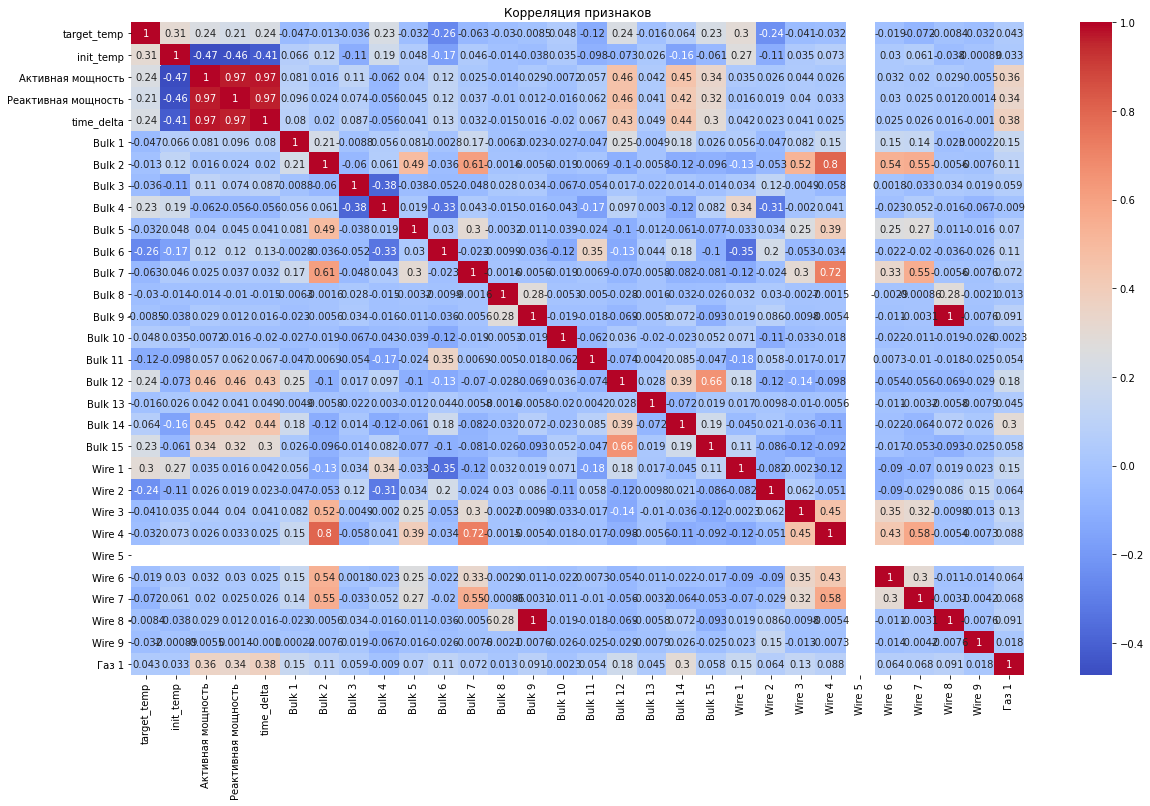

In [56]:
import seaborn as sns
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(df.corr(method='spearman'), annot=True, cmap="coolwarm")
plt.show()

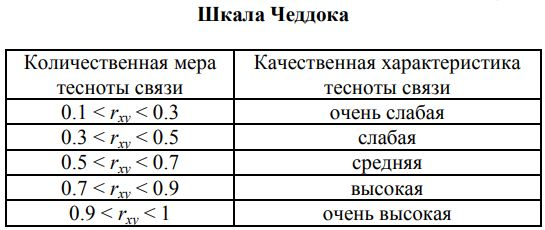

#### Conclusion
From the corelation triangle, we see that we have a noticeable correlation between:
1. time_delta and active and reactive power.
2. Bulk 7 и Bulk 2
3. Wire 8 and Bulk 9

While the first is natural, the second and third are not so obvious, while Wire 8 and Bulk 9 are completely different processes.

We remove features between which the correlation is higher than 0.9

In [57]:
df = df.drop(columns=['Wire 5','Wire 8','Реактивная мощность','time_delta'])

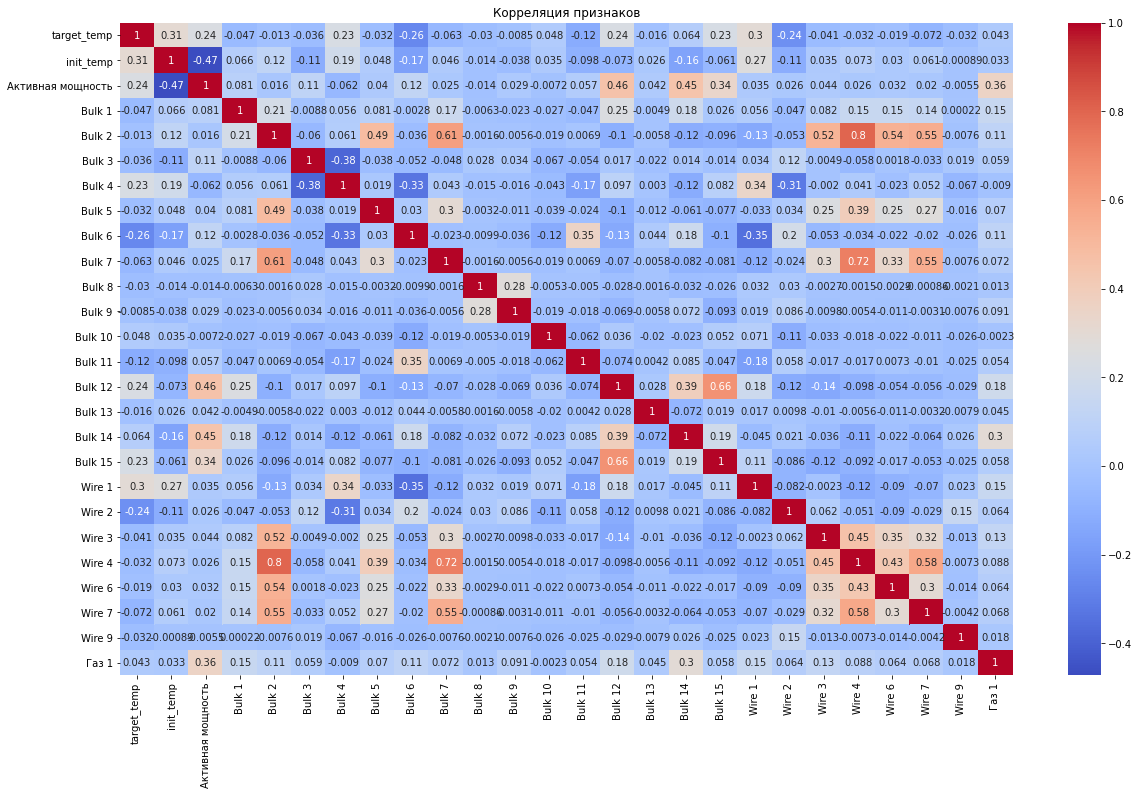

In [58]:
import seaborn as sns
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(df.corr(method='spearman'), annot=True, cmap="coolwarm")
plt.show()

### Preparing samples
Let's break it down into training and test sets

In [59]:
target = df['target_temp']
features = df.drop(columns='target_temp')

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=TEST_SPLIT, 
                                                                              random_state=RANDOM_STATE)

The sample size is very small!

In [60]:
print('train:',features_train.shape[0])
print('valid:',features_test.shape[0])

train: 1746
valid: 582


In [61]:
train_dataset = cb.Pool(features_train, target_train) 
test_dataset = cb.Pool(features_test, target_test)


### Model training

#### CatBoostRegressor

In [62]:
model_cb = cb.CatBoostRegressor(loss_function='MAE', random_seed=RANDOM_STATE)

In [63]:
%%time
grid = {'iterations': [100, 150, 200]
        ,'learning_rate': [0.01, 0.03, 0.1]
        ,'depth': [2, 3, 4, 6]
        ,'l2_leaf_reg': [0.1, 0.2, 0.5, 1, 3]}

grid_search_cb = model_cb.grid_search(grid, train_dataset, verbose=False, cv=3, partition_random_seed=RANDOM_STATE)

0:	learn: 1577.6289320	test: 1577.1387708	best: 1577.1387708 (0)	total: 58.1ms	remaining: 5.75s
1:	learn: 1561.8664284	test: 1561.3790248	best: 1561.3790248 (1)	total: 59.2ms	remaining: 2.9s
2:	learn: 1546.2505816	test: 1545.7643126	best: 1545.7643126 (2)	total: 60.4ms	remaining: 1.95s
3:	learn: 1530.7968135	test: 1530.3106379	best: 1530.3106379 (3)	total: 61.5ms	remaining: 1.48s
4:	learn: 1515.4982184	test: 1515.0121056	best: 1515.0121056 (4)	total: 62.5ms	remaining: 1.19s
5:	learn: 1500.3510251	test: 1499.8666844	best: 1499.8666844 (5)	total: 63.6ms	remaining: 996ms
6:	learn: 1485.3537291	test: 1484.8695520	best: 1484.8695520 (6)	total: 64.7ms	remaining: 859ms
7:	learn: 1470.5070115	test: 1470.0251221	best: 1470.0251221 (7)	total: 65.7ms	remaining: 756ms
8:	learn: 1455.8134335	test: 1455.3339619	best: 1455.3339619 (8)	total: 66.8ms	remaining: 675ms
9:	learn: 1441.2609623	test: 1440.7820490	best: 1440.7820490 (9)	total: 68ms	remaining: 612ms
10:	learn: 1426.8554208	test: 1426.3762595	

In [64]:
print('Best score on train:')
print(model_cb.get_best_score())

Best score on train:
{'learn': {'MAE': 5.388009636996184}}


#### DecisionTreeRegressor

In [65]:
%%time

param = {
    'max_depth': randint(1, 80)
    , 'min_samples_leaf': randint(1, 80)
    , 'min_samples_split': randint(2, 100)
    ,
}

model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

randomsearch = RandomizedSearchCV(model_dt
                                  , param_distributions=param
                                  , n_iter=10000
                                  , cv=5
                                  , n_jobs=-1
                                  , scoring = 'neg_mean_absolute_error'
                                  , return_train_score=True
                                  , random_state=RANDOM_STATE)

randomsearch.fit(features_train, target_train)
print('Best score:', np.abs(randomsearch.best_score_))
print('Best params:', randomsearch.best_params_)

Best score: 6.711719373597356
Best params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 46}
CPU times: user 10 s, sys: 901 ms, total: 10.9 s
Wall time: 59.2 s


#### LinearRegression

Feature scaling in case we use linear regression results to build a feature significance diagram.

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(features_train)

X = scaler.transform(features_train)
X_test = scaler.transform(features_test)

Training

In [67]:
%%time
model_lr = LinearRegression()

scores = cross_val_score(model_lr
                , X
                , target_train
                , scoring = 'neg_mean_absolute_error'
                , cv=3)

mae_score = scores.mean()

print(f'MAE: {np.abs(mae_score)}')

MAE: 6.573208948180283
CPU times: user 1.47 s, sys: 1.38 s, total: 2.86 s
Wall time: 392 ms


#### Conclusion
MAE cross-validation results for models are as follows:
- LinearRegression 6.57
- DecisionTreeRegressor 6.71
- Cat boost 5.38

CatBoost model wins by a margin

### Checking on a test set

In [68]:
pred = model_cb.predict(features_test)
mae = mean_absolute_error(target_test, pred)
print('MAE test: {:.2f}'.format(mae))

MAE test: 6.24


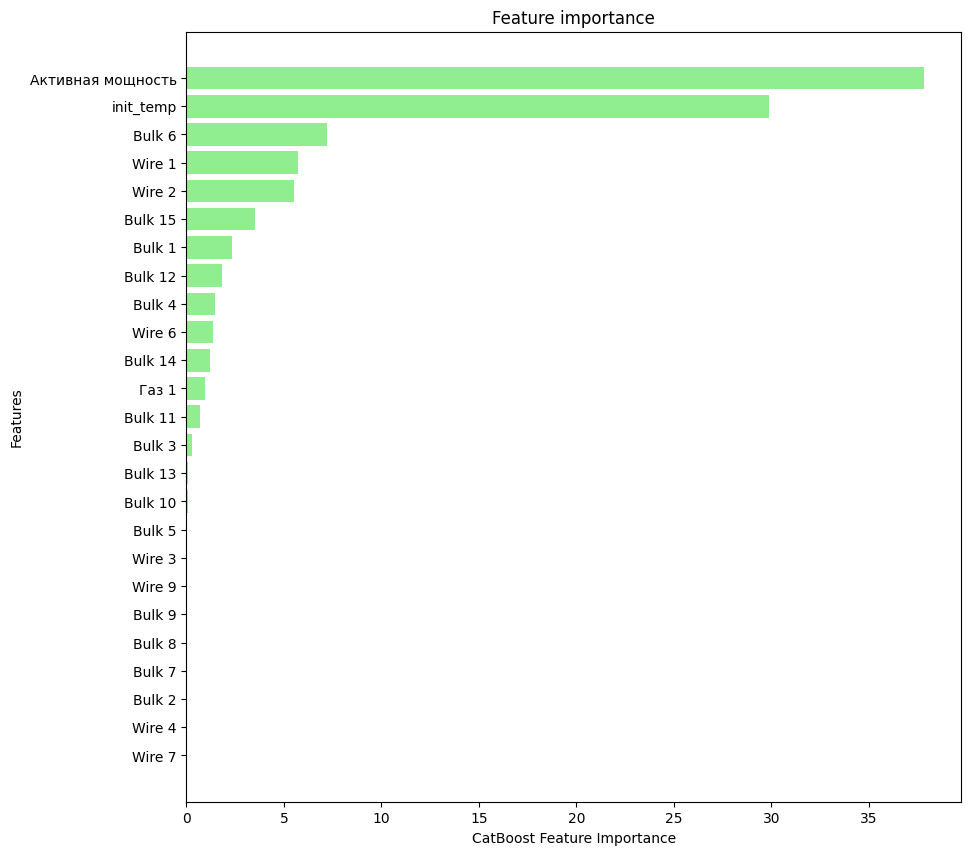

In [69]:
sorted_feature_importance = model_cb.feature_importances_.argsort()
fig = plt.figure(figsize=(10, 10))
plt.barh(features_train.columns.values[sorted_feature_importance], 
        model_cb.feature_importances_[sorted_feature_importance], 
        color='lightgreen')
plt.xlabel("CatBoost Feature Importance")
plt.ylabel("Features")
plt.title("Feature importance")
plt.show();

### Conclusion
Achieved MAE = 6.24 on the test set.

A feature significance diagram has also been constructed, according to which we can say that we can discard 14 features and this will not dramatically affect the quality of our model.
The most significant signs:
- init_temp - initial steel temperature.
- Active power - power that is used only for heating.
- time_delta - heating time.

# Report

## Problem to be solved.
### Description of the task
In order to optimize production costs, the metallurgical plant Tak Temper Steel LLC decided to reduce electricity consumption at the stage of steel processing. A model is to be built that will predict the steel temperature.

### Description of the technological process

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus (English tribe, "mass").

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks (English *slab*, “slab”).

### Description of data

The data consists of files obtained from different sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` *—* data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. There can be several lines in files with the same `key` value: they correspond to different processing iterations.

## Description solutions
The problem was solved in several stages:
1. Analysis of initial data
- search and removal of choices
- analysis of the normality of distributions
- adding features
2. List of planned works
3. Preprocessing tables
- cast
- data aggregation by key
- filling in blanks
4. Merging tables
5. Preprocessing of the merged data
- clear from NaN
- preparation of signs
6. Correlation matrix
- analysis of the dependence of signs on each other
- removal of codependent signs
7. Preparation of samples
- selected target feature
- training and test samples were created.
8. Choice of models and metrics
- three machine learning models selected for the testing phase
- selection of hyperparameters using RandomizedSearch with cross-validation
9. Choosing the best model
- testing the best model on a test set
- Significance diagram.
10. Conclusion


In the process of doing the work (point 1), we found an outlier in reactive power values, which was removed.
Also, the distributions of quantities are not abnormal7 Their distribution is closer to the Poisson distribution based on the visual analysis of the graphs. For the `data_arc` table, additional features were calculated from the data to us, namely: heating time (time_temp), total power (S) and work (A).

In the process of preprocessing (point 3), data types (for example, dates) were given. The data_arc table is grouped by `key` using the aggregating function `sum()`. In tables `data_bulk`, `data_wire` NaN are filled with zeros. From the table `data_temp` removed rows with NaN, as well as rows with a single occurrence of the key key

Then we performed the union (point 4) of the following tables by the `key` field:
- max_data_temp
- min_data_temp
- data_arc
- data_bulk
- data_wire
- data_gas

The `target attribute` is highlighted - the final heating temperature (point 5), which we will receive as the latest temperature value from the `data_temp` table for each `key` value. in the same way, from the table `data_temp` we get the value of the initial heating temperature, taking the temperature value initially in time.

A `correlation matrix` has been built (point 6). Since the distribution law is not normal, the Spearman correlation is used.

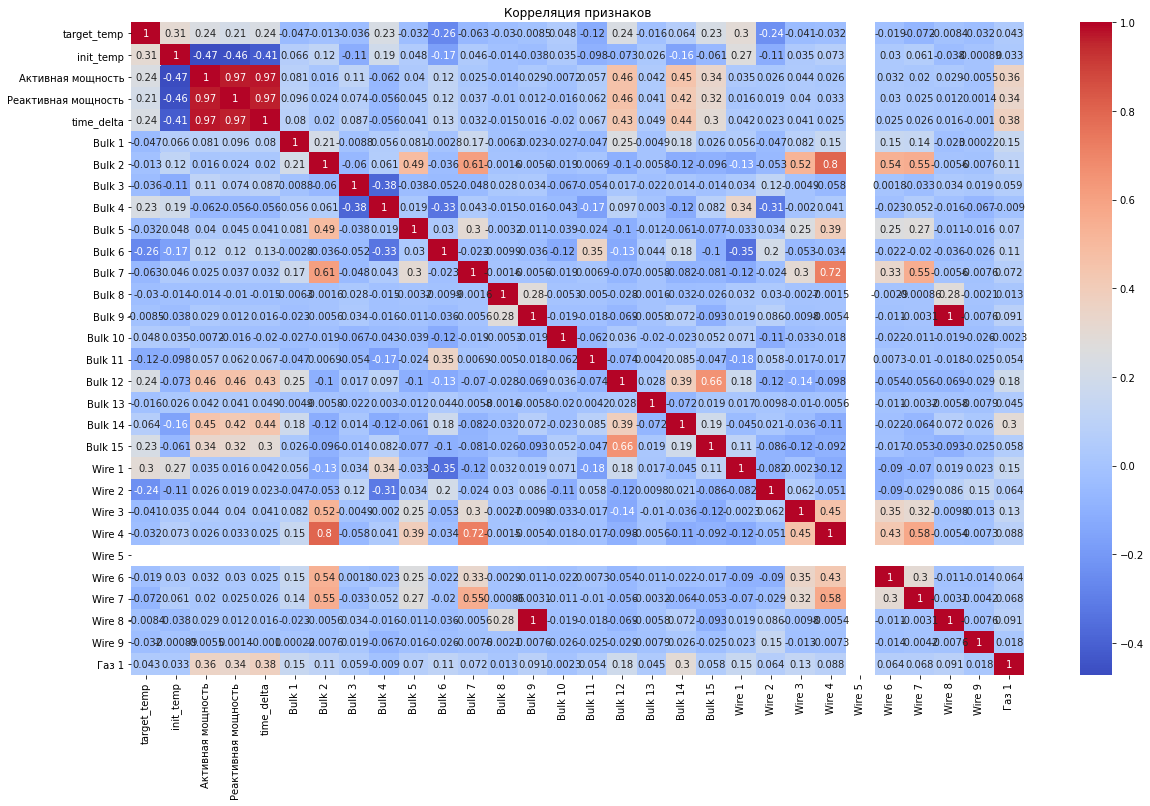

Removed the following features:
- `Wire 5` - no correlation.
- `Wire 8`, `Reactive power`, `time_delta` - strong correlation with the feature `Active power`.

Next, a training (75%) and test (25%) sample was prepared (point 7).
For the linear regression model, the features were further scaled.

Three machine learning models are selected (item 8):
- Linear regression
- Random forest
- CatBoost

MAE metric.

The selection of hyperparameters was carried out using RandomizedSearchCV.
According to the results of cross-validation, the CatBoost model with MAE = 5.388 turned out to be the best.

## Solution result
As a result of solving on test data with the CatBoost model, we got the value MAE = 6.24.
Which is a good result, but in theory you can try to achieve a slightly better result by spending much more time.

## Model factors, including importance plot.
Below is a graph of the significance of the features of the CatBoost model:

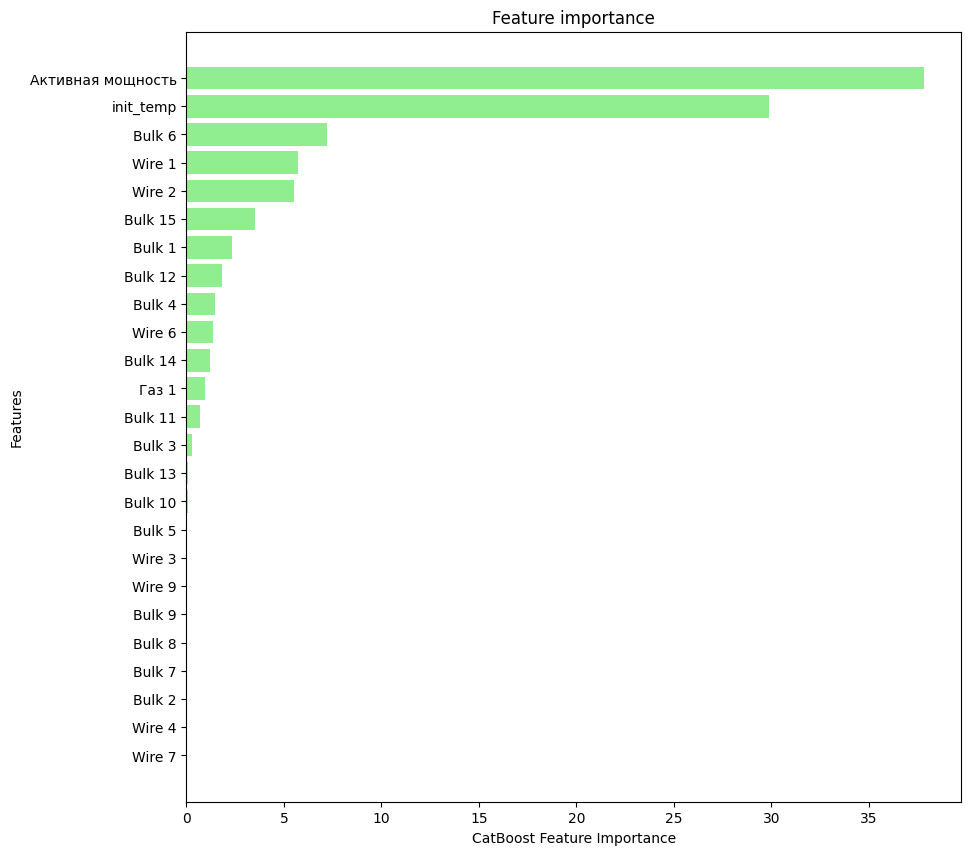

As you can see, the most significant sign is `Active power`, which is natural and physically justified.
Next is `initial_temp` (initial temperature).
And then the signs of Bulk and Wire.

We can note that there are features (eg Wire 7) that contribute too little to the model and therefore can be excluded. The influence of these features on the quality of the model and the speed of its work may be the subject of further research.

### Which items of the plan were completed and which were not (explain why)?
All points of the plan were completed.
### What challenges did you face and how did you overcome them?
During the work, there were difficulties with the visualization of the learning process of the CatBoost model (perhaps due to its launch on the ARM platform). Therefore, visualization was disabled.
### What are the key steps in solving the problem identified?
The key steps are to determine the target feature, as well as feature correlations for model training and their removal.
### What is your final model and what is its quality?
Final model: CatBoostRegresor, MAE metric = 6.24